In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
data_path = './glucose_dataset.csv'
data = pd.read_csv(data_path)


FileNotFoundError: [Errno 2] No such file or directory: './glucose_dataset.csv'

In [28]:
data['DKA'] = ((data['FPG'] >= 13.9) |
               (data['BUN'] > 7) |
               (data['ALT'] > 40)).astype(int)



In [29]:
data['Diabetic_Retinopathy'] = ((data['HighBP'] == 1) |
                                (data['FPG'] > 6) |
                                (data['Chol'] > 5.5) |
                                (data['Tri'] > 2) |
                                (data['HDL'] < 1.1) |
                                (data['LDL'] > 3.3)).astype(int)



In [30]:
data['NAFLD'] = ((data['BMI'] >= 25) |
                 ((data['ALT'] > 35) & (data['Gender'] == 'Male')) |
                 ((data['ALT'] > 25) & (data['Gender'] == 'Female')) |
                 (data['Chol'] > 5.2) |
                 (data['Tri'] > 1.7)).astype(int)

In [58]:
data['Diabetic_Neuropathy'] = ((data['BMI'] > 30) |
                               (data['FPG'] > 7) |
                               (data['Chol'] > 5.2) |
                               (data['Tri'] > 1.7)).astype(int)

In [32]:
import ace_tools as tools; tools.display_dataframe_to_user(name="Dataset with Disease Indicators", dataframe=data)

ModuleNotFoundError: No module named 'ace_tools'

In [33]:
%pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


In [43]:
print(data)

        Diabetes  HighBP  HighChol  CholCheck   BMI  smoking  Stroke  \
0              0     0.0       0.0        1.0  25.0        0     0.0   
1              0     0.0       0.0        1.0  25.0        0     0.0   
2              0     0.0       0.0        1.0  25.0        0     0.0   
3              0     0.0       0.0        1.0  25.0        0     0.0   
4              0     0.0       0.0        1.0  25.0        0     0.0   
...          ...     ...       ...        ...   ...      ...     ...   
199943         0     0.0       0.0        1.0  25.0        1     0.0   
199944         0     0.0       0.0        1.0  25.0        1     0.0   
199945         0     0.0       0.0        1.0  25.0        1     0.0   
199946         0     1.0       1.0        1.0  25.0        1     0.0   
199947         0     0.0       0.0        1.0  25.0        1     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  ...    ALT   BUN   CCR  \
0                        0.0           1.0     1.0  ...  

In [59]:
disease_columns = ['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']
data[disease_columns].apply(pd.Series.value_counts)

DKA  Diabetic_Retinopathy   NAFLD  Diabetic_Neuropathy
0  162196                 71785   58895                96592
1   37752                128163  141053               103356

<Figure size 1000x800 with 0 Axes>

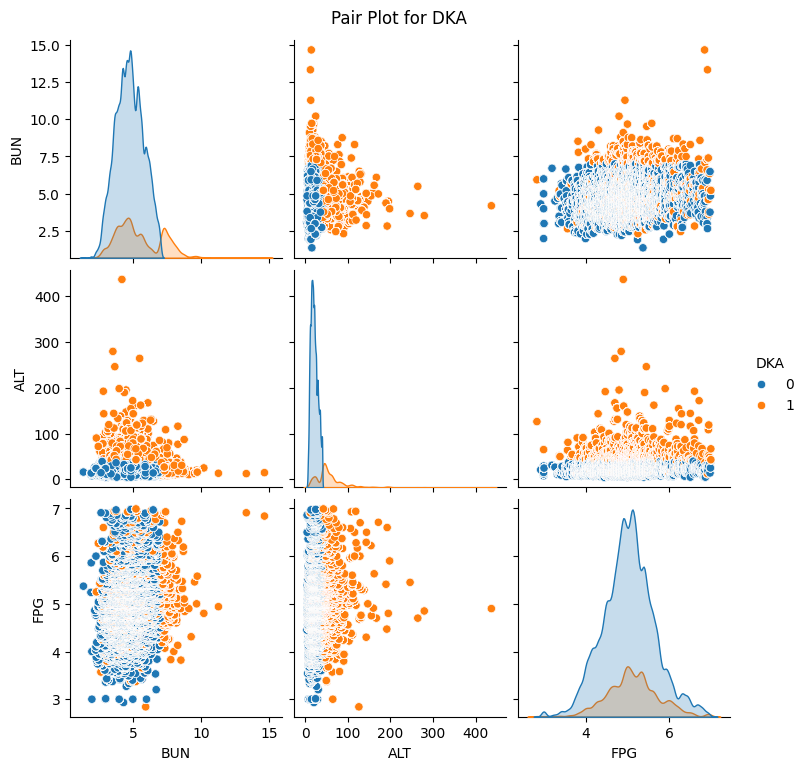

<Figure size 1000x800 with 0 Axes>

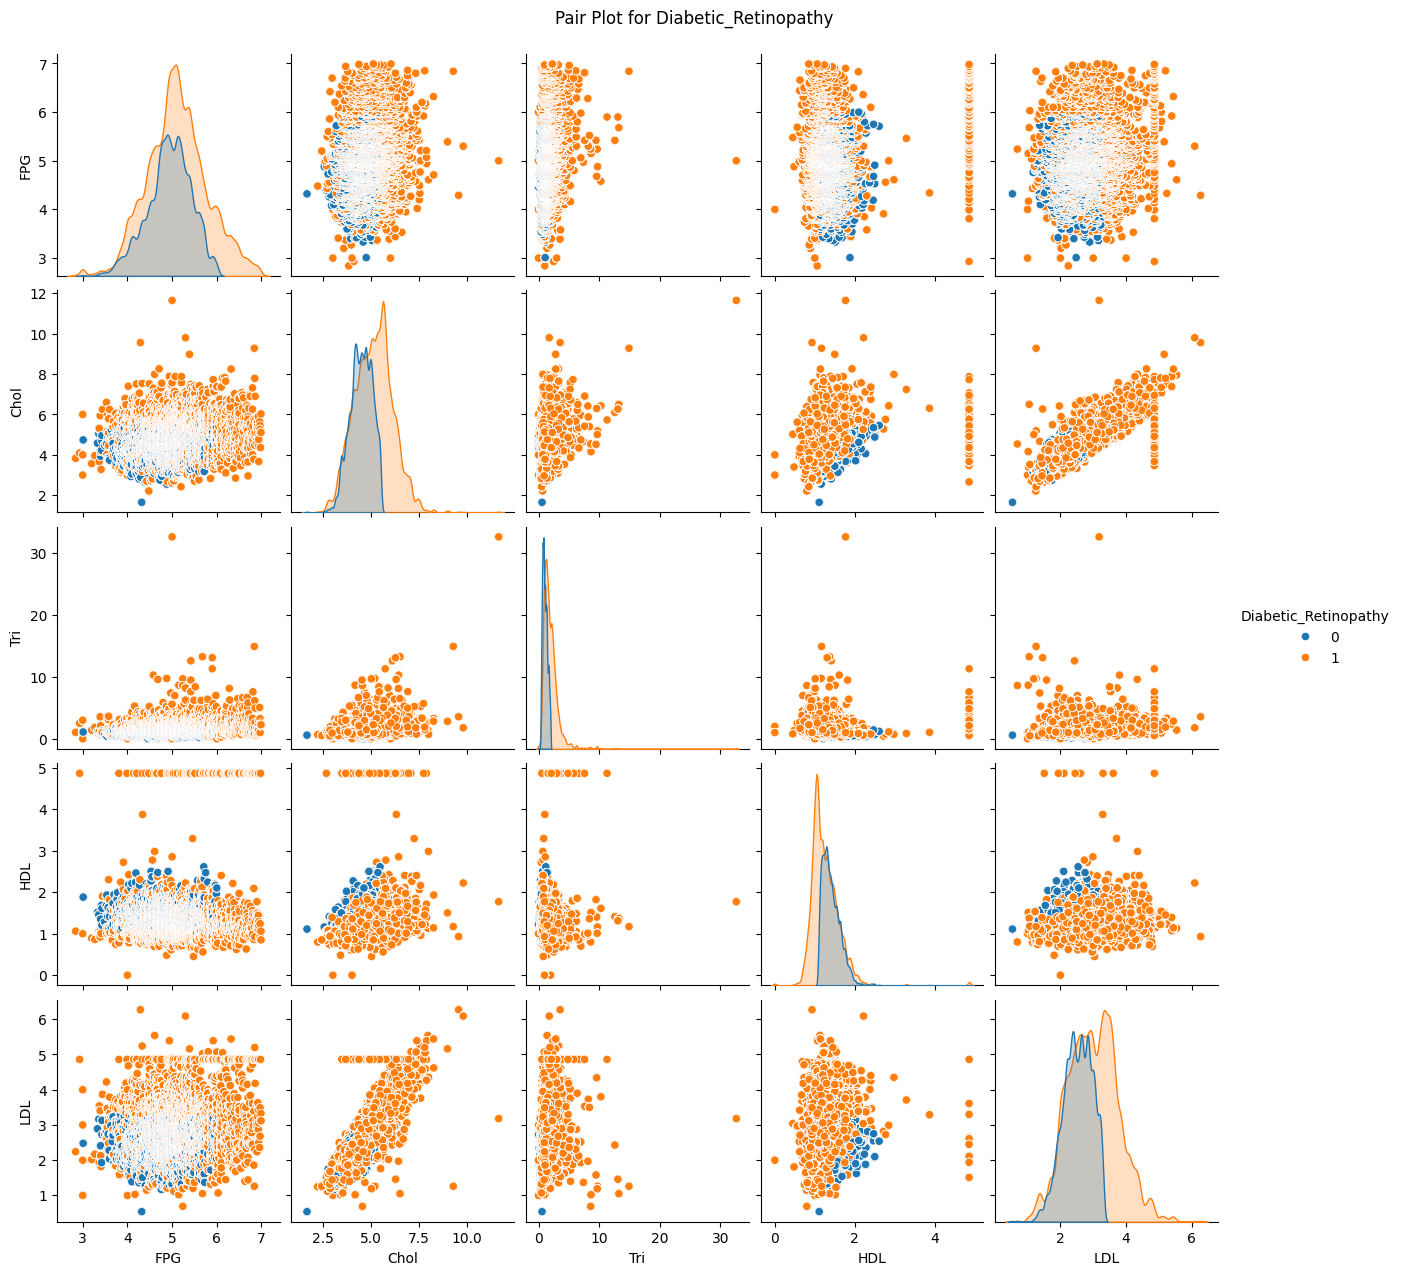

<Figure size 1000x800 with 0 Axes>

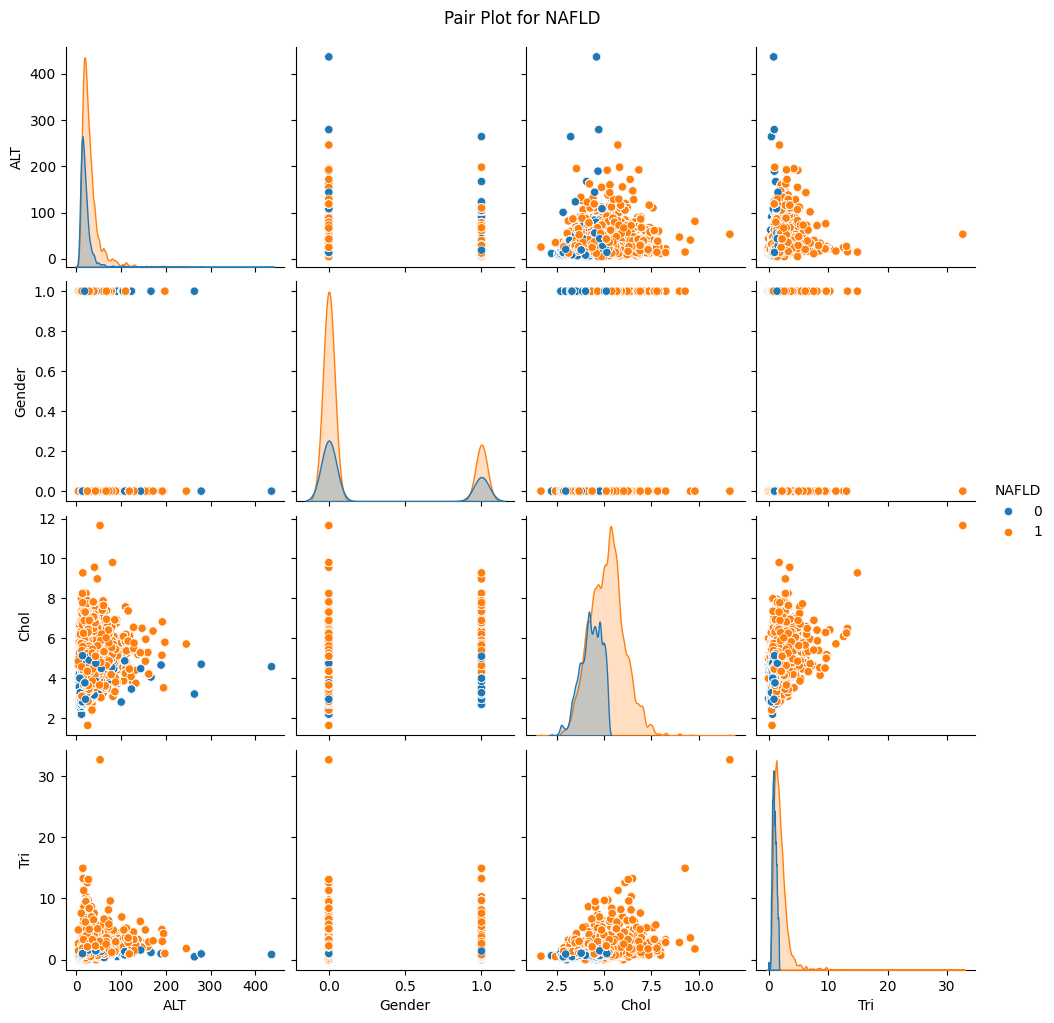

<Figure size 1000x800 with 0 Axes>

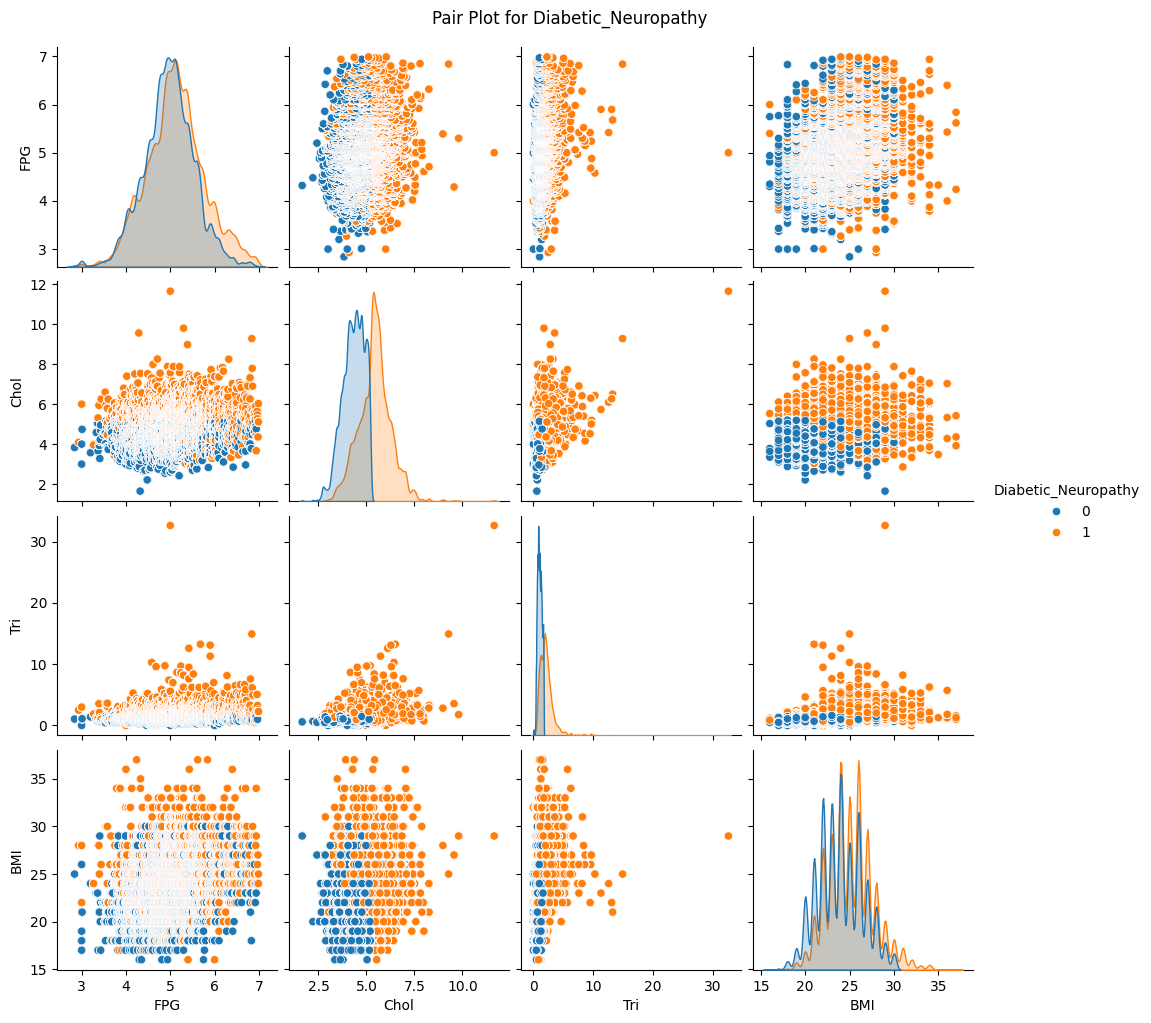

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the feature lists for each disease
disease_features = {
    'DKA': ['BUN','ALT', 'FPG'],
    'Diabetic_Retinopathy': ['FPG', 'Chol', 'Tri', 'HDL', 'LDL'],
    'NAFLD': ['ALT', 'Gender', 'Chol', 'Tri'],
    'Diabetic_Neuropathy': ['FPG', 'Chol', 'Tri','BMI']
}

# Iterate through each target disease column and create a pair plot
for disease, features in disease_features.items():
    plt.figure(figsize=(10, 8))
    sns.pairplot(data, hue=disease, vars=features)
    plt.suptitle(f"Pair Plot for {disease}", y=1.02)  # Adjust title position slightly above
    plt.show()

In [65]:
%pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [67]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame with 'DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy'
diseases = ['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']

# Create a dictionary to store resampled datasets for each disease
resampled_data = {}

# Loop over each disease
for disease in diseases:
    # Select features (X) and target (y) for each disease
    X = data.drop(columns=diseases)
    y = data[disease]
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTETomek
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
    
    # Store the resampled data
    resampled_data[disease] = (X_resampled, y_resampled)

# Now we have resampled datasets for each disease in 'resampled_data'


<Figure size 1000x800 with 0 Axes>

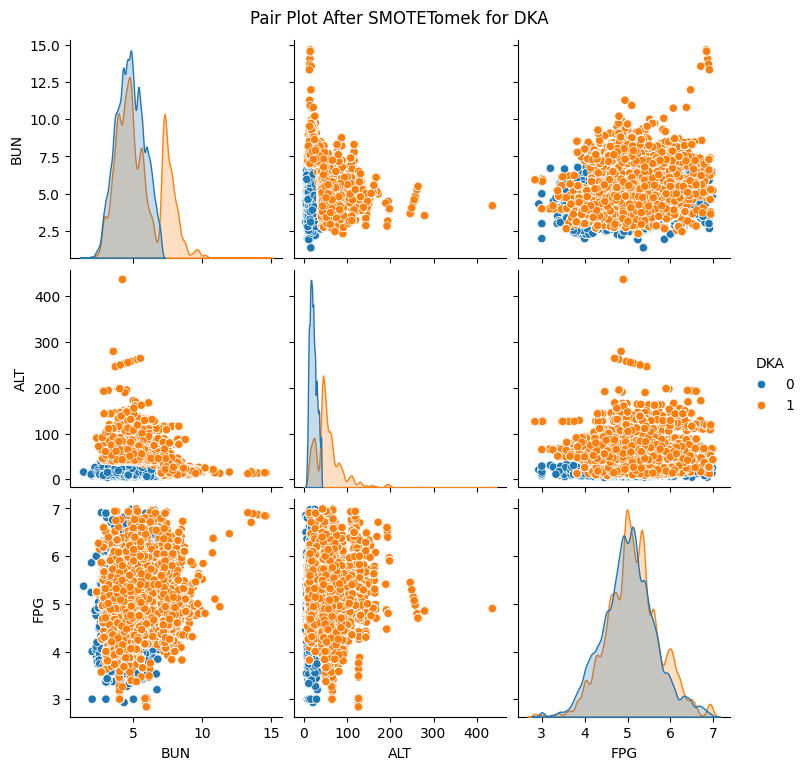

<Figure size 1000x800 with 0 Axes>

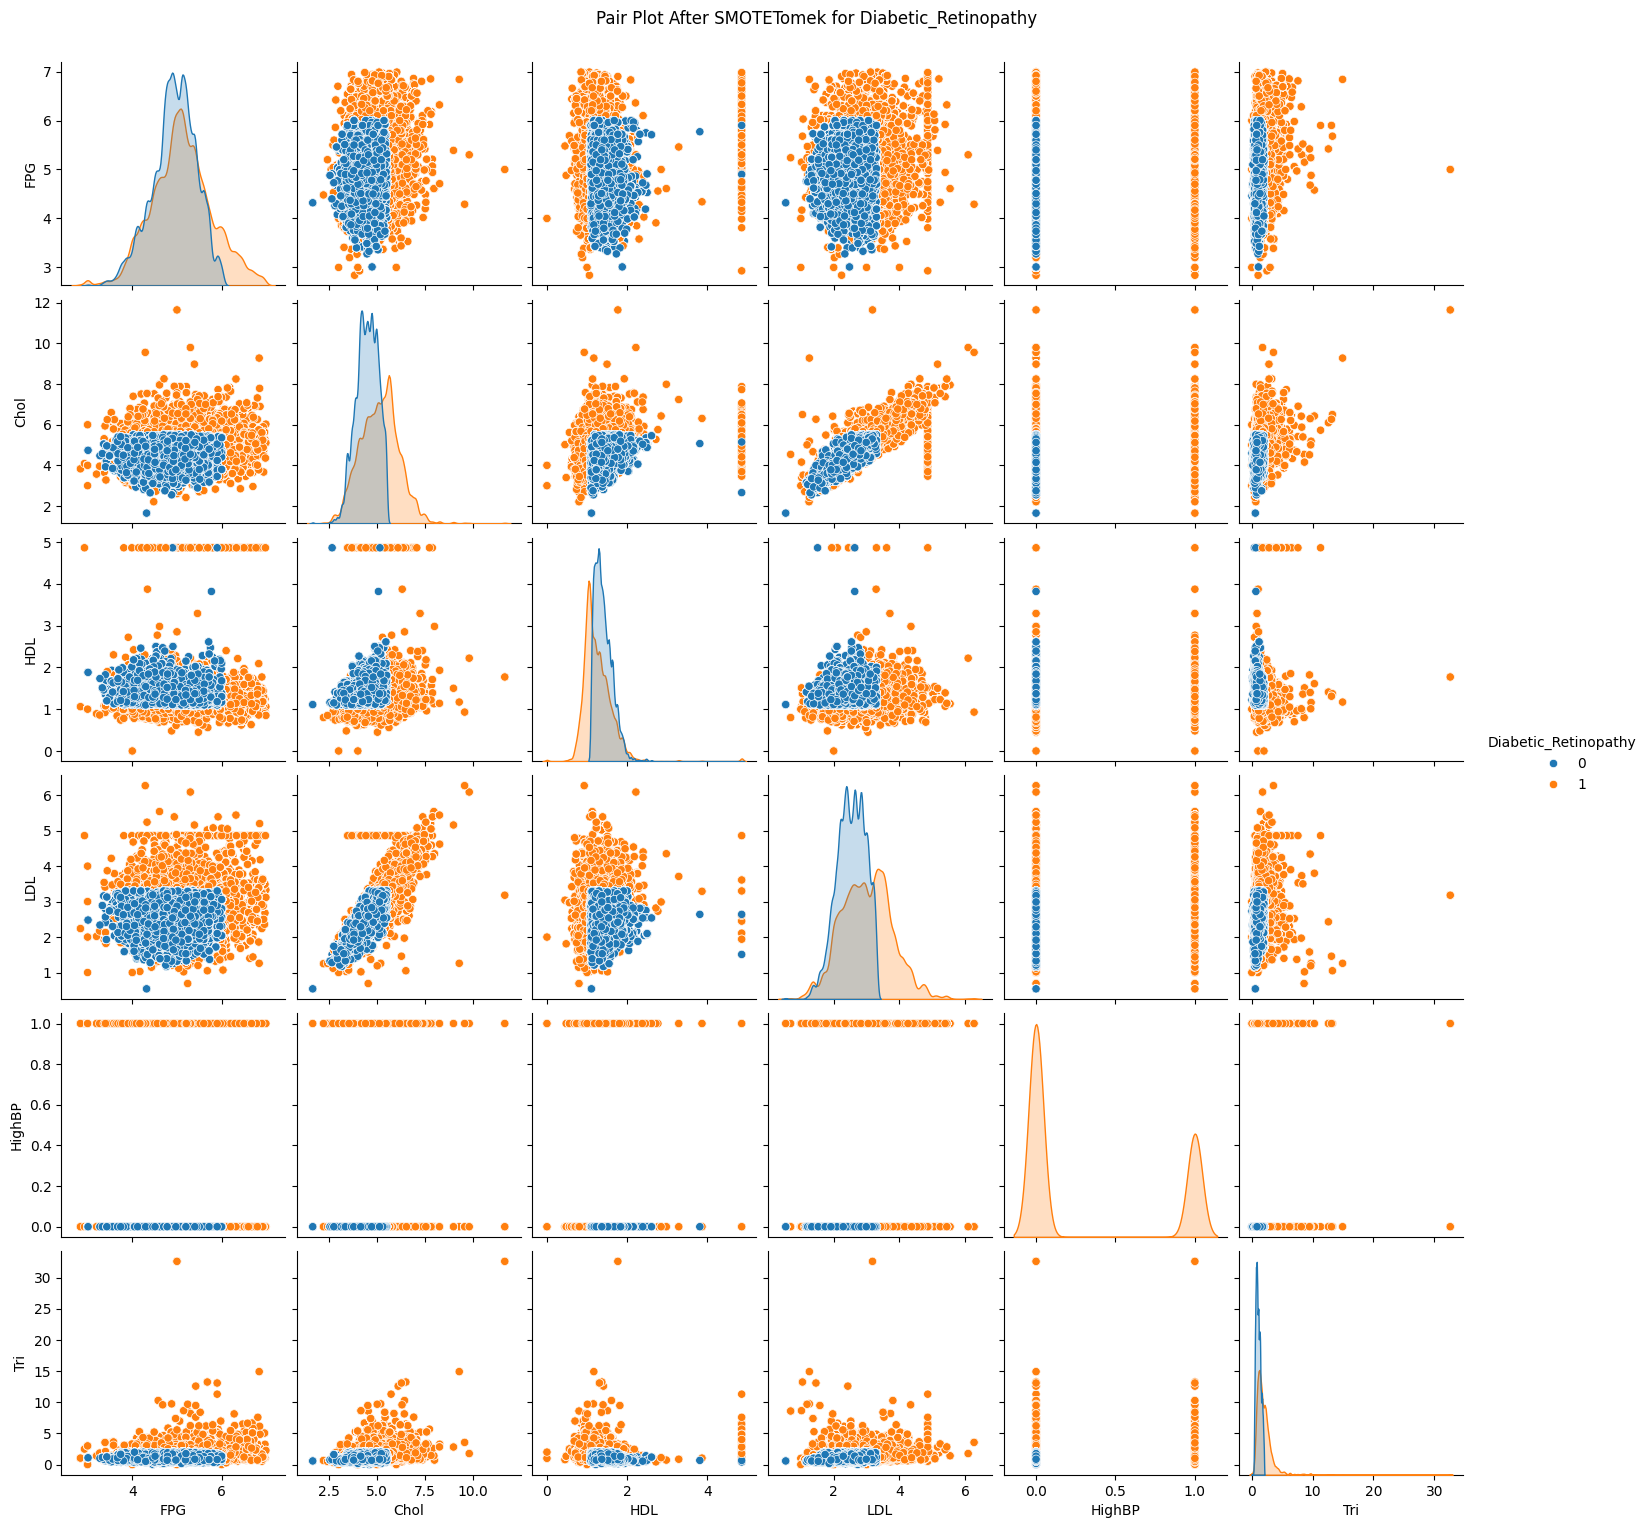

<Figure size 1000x800 with 0 Axes>

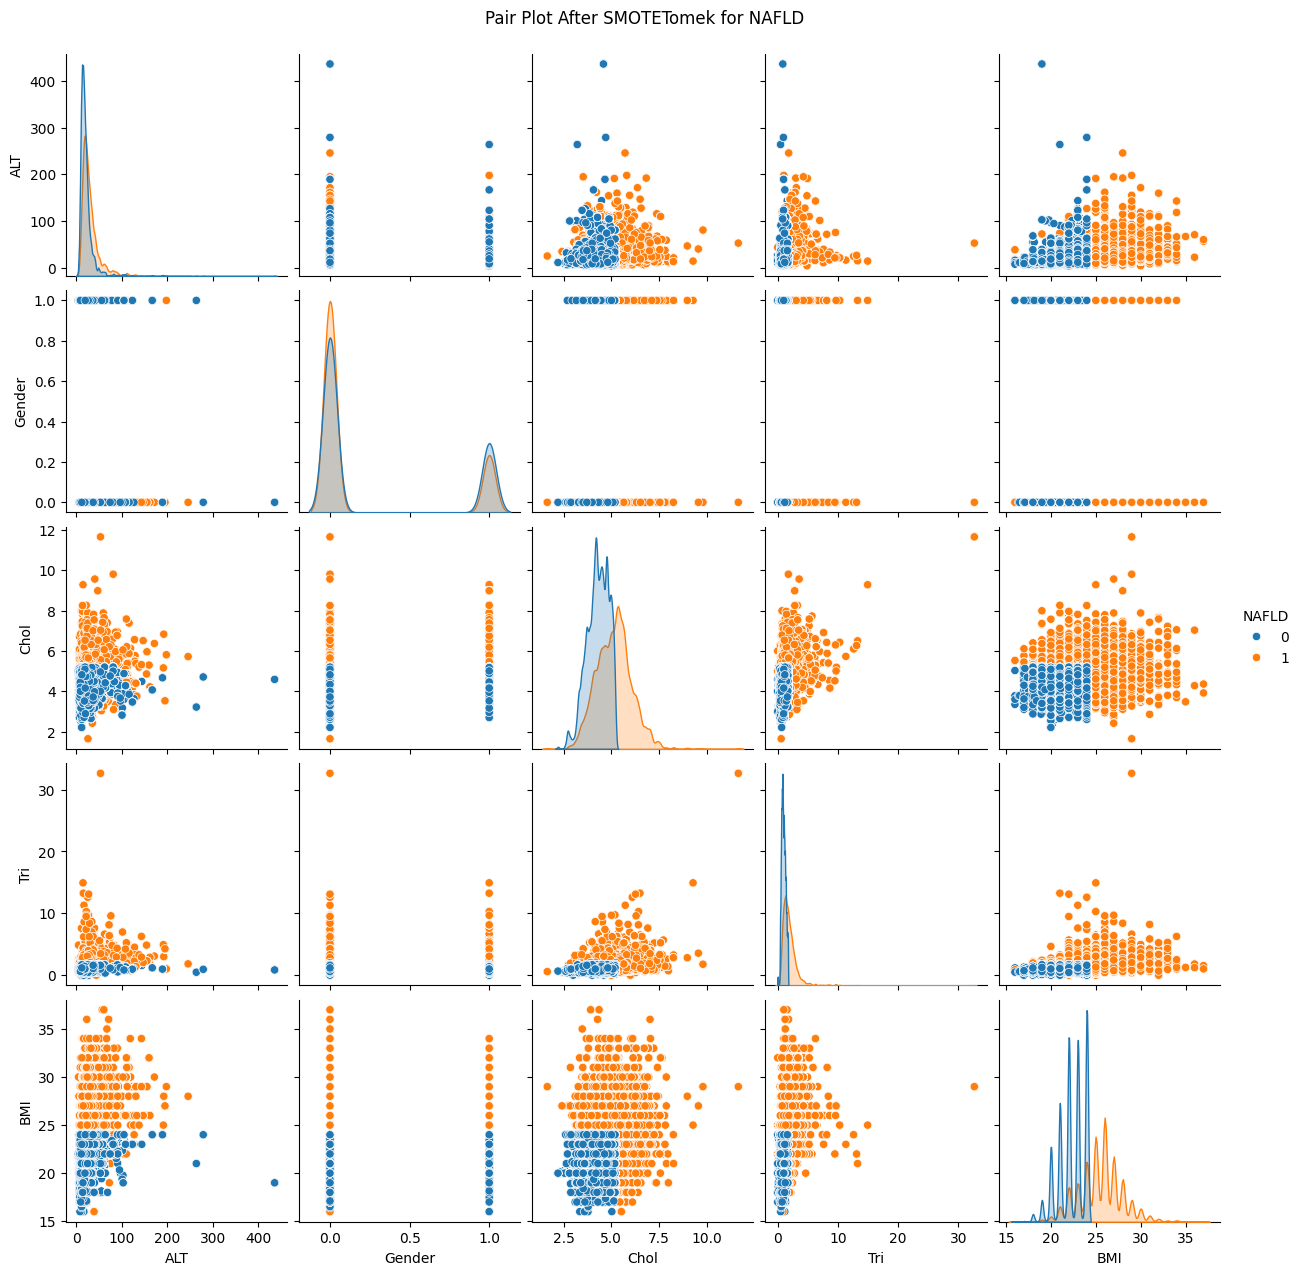

<Figure size 1000x800 with 0 Axes>

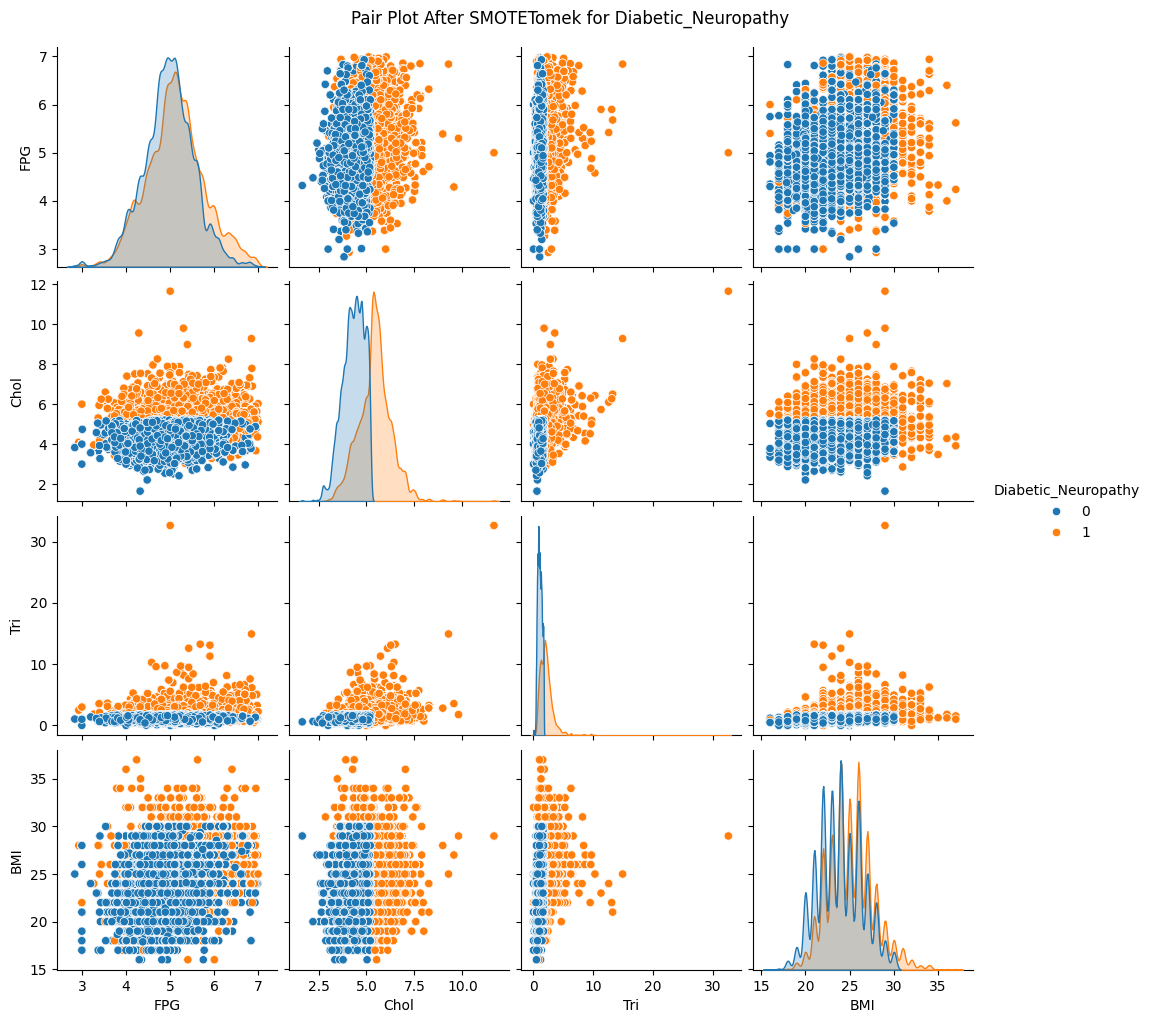

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'resampled_data' contains the resampled datasets for each disease
for disease in resampled_data.keys():
    X_resampled, y_resampled = resampled_data[disease]

    # Create a temporary DataFrame for visualization
    df_resampled = X_resampled.copy()
    df_resampled[disease] = y_resampled  # Add the target column back for hue

    # Select a few important features for visualization based on the disease
    if disease == 'DKA':
        features = ['BUN', 'ALT', 'FPG']  # Adjust based on your dataset
    elif disease == 'Diabetic_Retinopathy':
        features = ['FPG', 'Chol', 'HDL', 'LDL','HighBP','Tri']  # Adjust based on your dataset
    elif disease == 'NAFLD':
        features = ['ALT', 'Gender', 'Chol', 'Tri','BMI']  # Adjust based on your dataset
    elif disease == 'Diabetic_Neuropathy':
        features = ['FPG', 'Chol', 'Tri', 'BMI']  # Adjust based on your dataset

    # Plot the pair plot for the resampled data
    plt.figure(figsize=(10, 8))
    sns.pairplot(df_resampled, hue=disease, vars=features)
    plt.suptitle(f"Pair Plot After SMOTETomek for {disease}", y=1.02)
    plt.show()


In [70]:
%pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [75]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame with 'DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy'
diseases = ['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']

# Create a dictionary to store resampled datasets for each disease
resampled_data_smote = {}

# Loop over each disease
for disease in diseases:
    # Select features (X) and target (y) for each disease
    X = data.drop(columns=diseases)
    y = data[disease]
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTETomek to clean the boundary
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
    
    # Reapply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_resampled, y_resampled)
    
    # Store the balanced data
    resampled_data_smote[disease] = (X_balanced, y_balanced)

# Now 'resampled_data_smote' contains balanced datasets after applying SMOTETomek + SMOTE


<Figure size 1000x800 with 0 Axes>

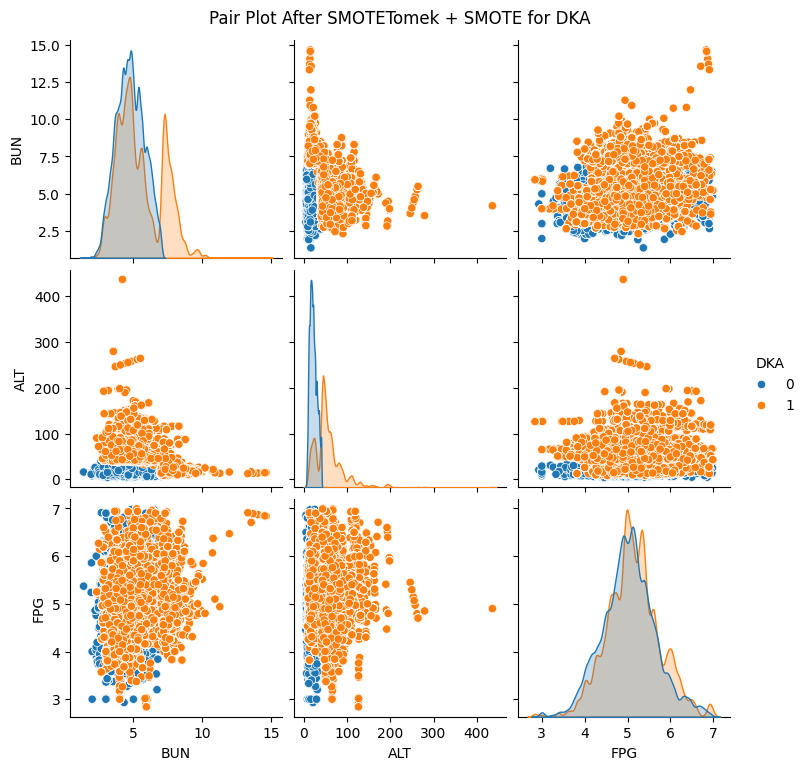

<Figure size 1000x800 with 0 Axes>

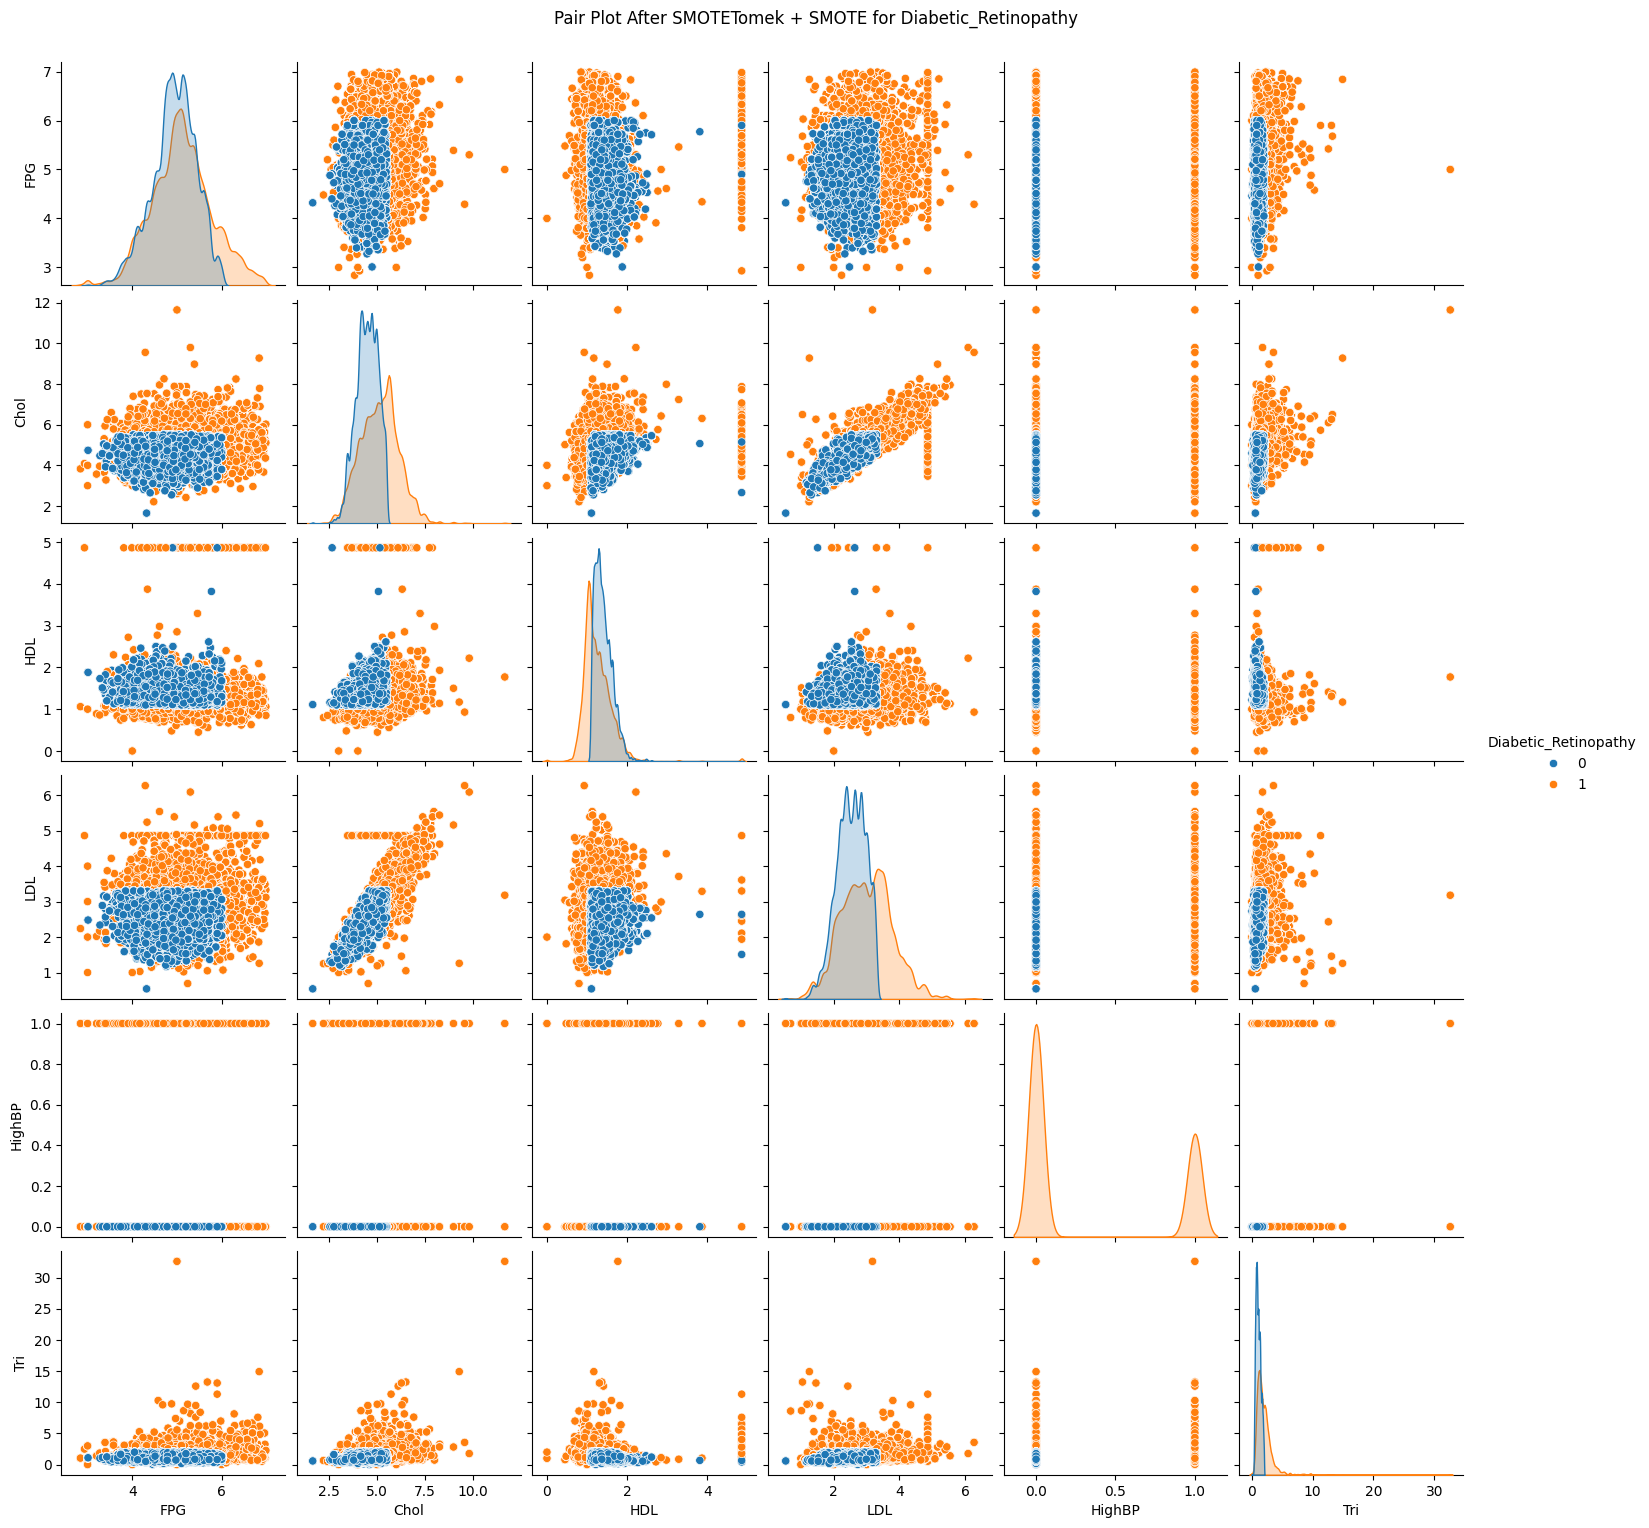

<Figure size 1000x800 with 0 Axes>

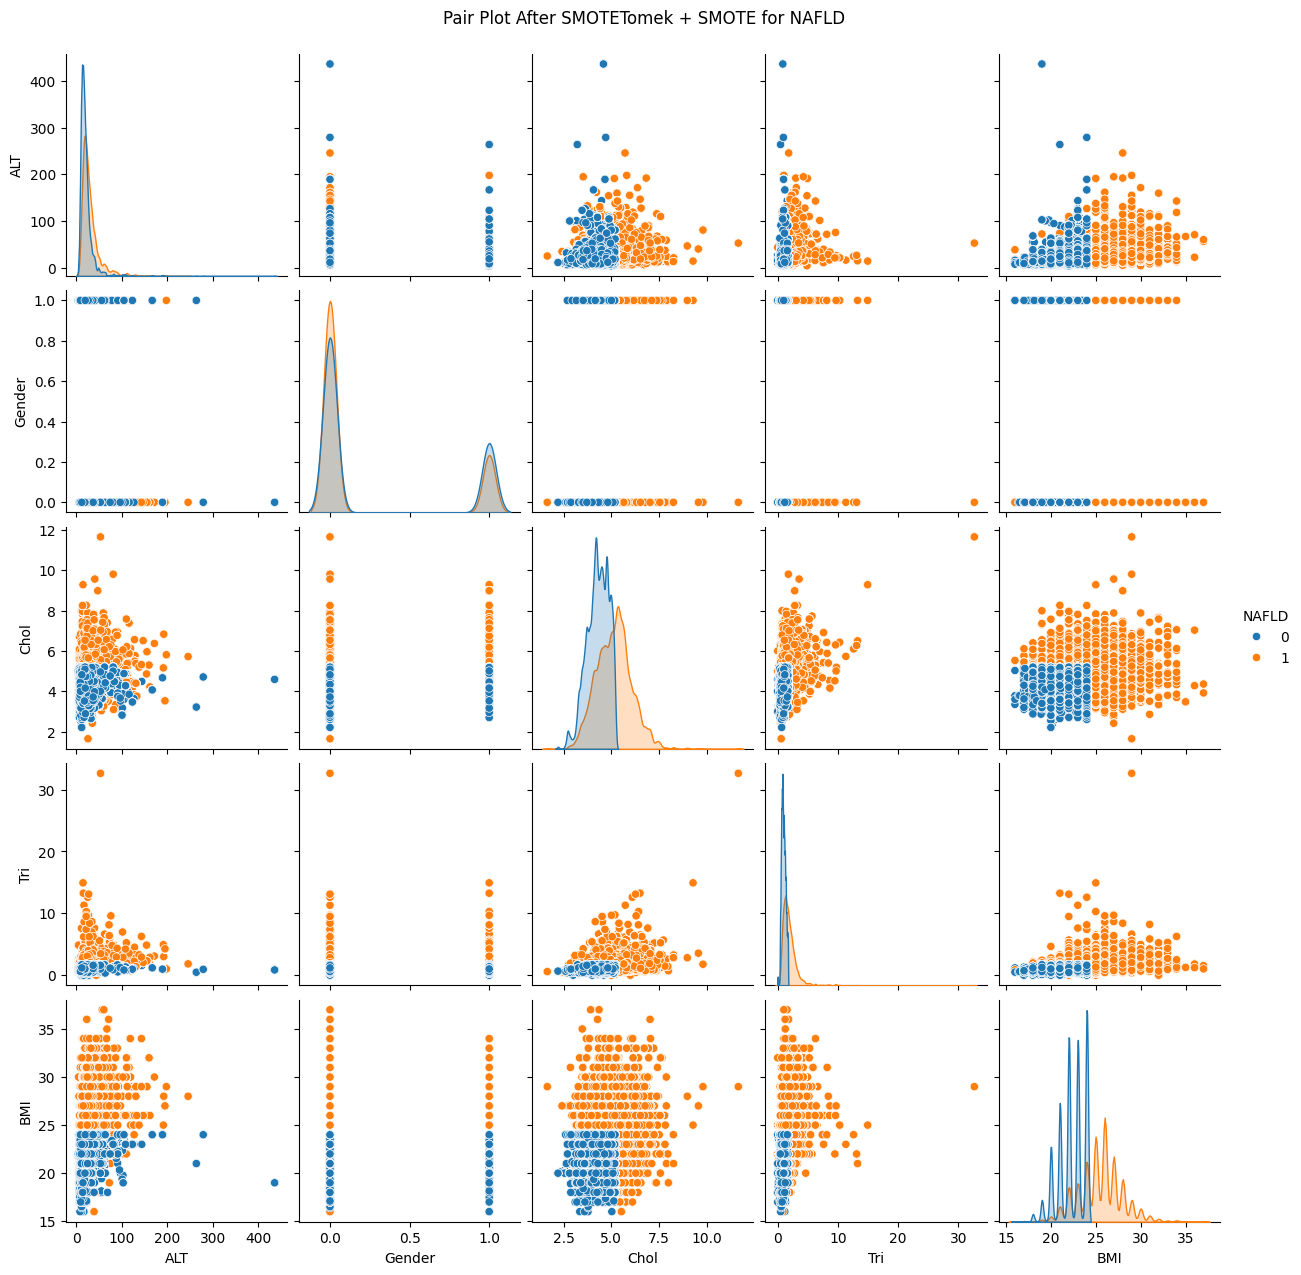

<Figure size 1000x800 with 0 Axes>

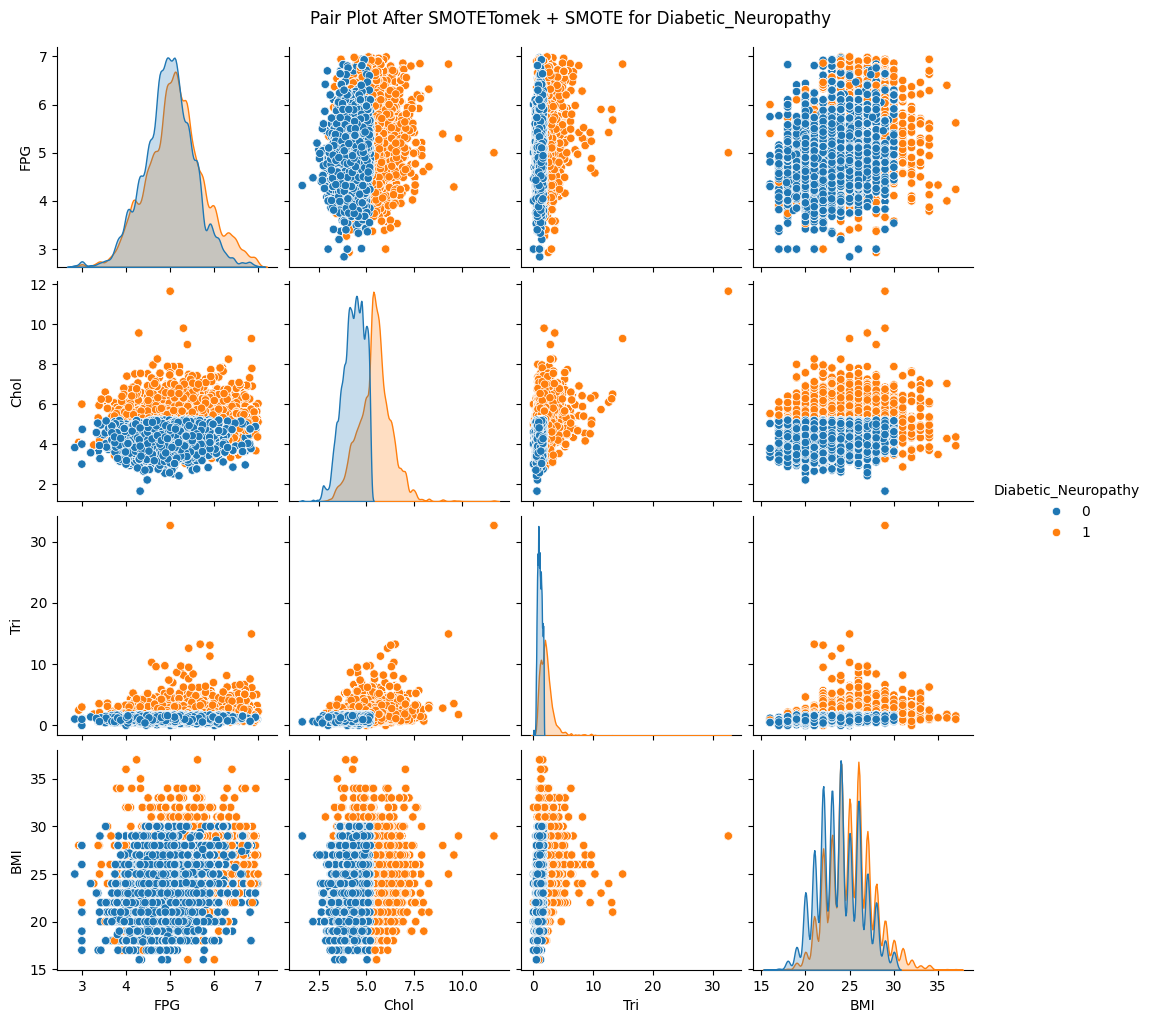

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize after applying SMOTETomek + SMOTE
for disease in resampled_data_smote.keys():
    X_balanced, y_balanced = resampled_data_smote[disease]

    # Create a temporary DataFrame for visualization
    df_balanced = X_balanced.copy()
    df_balanced[disease] = y_balanced  # Add the target column back for hue

    # Select a few important features for visualization based on the disease
    if disease == 'DKA':
        features = ['BUN', 'ALT', 'FPG']  # Adjust based on your dataset
    elif disease == 'Diabetic_Retinopathy':
        features = ['FPG', 'Chol', 'HDL', 'LDL','HighBP','Tri']  # Adjust based on your dataset
    elif disease == 'NAFLD':
        features = ['ALT', 'Gender', 'Chol', 'Tri','BMI']  # Adjust based on your dataset
    elif disease == 'Diabetic_Neuropathy':
        features = ['FPG', 'Chol', 'Tri', 'BMI'] # Adjust based on your dataset

    # Plot the pair plot for the balanced data
    plt.figure(figsize=(10, 8))
    sns.pairplot(df_balanced, hue=disease, vars=features)
    plt.suptitle(f"Pair Plot After SMOTETomek + SMOTE for {disease}", y=1.02)
    plt.show()


In [77]:
# Example: focusing on ALT (NAFLD), FPG (DKA), and BMI (Diabetic Neuropathy)
suspected_outlier_features = {
    'NAFLD': ['ALT'], 
    'DKA': ['FPG'], 
    'Diabetic_Neuropathy': ['BMI']
}


In [78]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest to detect outliers for each disease's key features
outliers_detected = {}

for disease, features in suspected_outlier_features.items():
    X_balanced, y_balanced = resampled_data_smote[disease]
    
    for feature in features:
        iso_forest = IsolationForest(contamination=0.01, random_state=42)
        outliers = iso_forest.fit_predict(X_balanced[[feature]])  # Only on the feature with outliers
        print(f"Outliers detected in {disease} ({feature}):", sum(outliers == -1))
        
        # Keep only non-outliers (where outliers != -1)
        X_filtered = X_balanced[outliers == 1]
        y_filtered = y_balanced[outliers == 1]
        
        # Store the filtered data
        outliers_detected[disease] = (X_filtered, y_filtered)


Outliers detected in NAFLD (ALT): 2192
Outliers detected in DKA (FPG): 2434
Outliers detected in Diabetic_Neuropathy (BMI): 1409


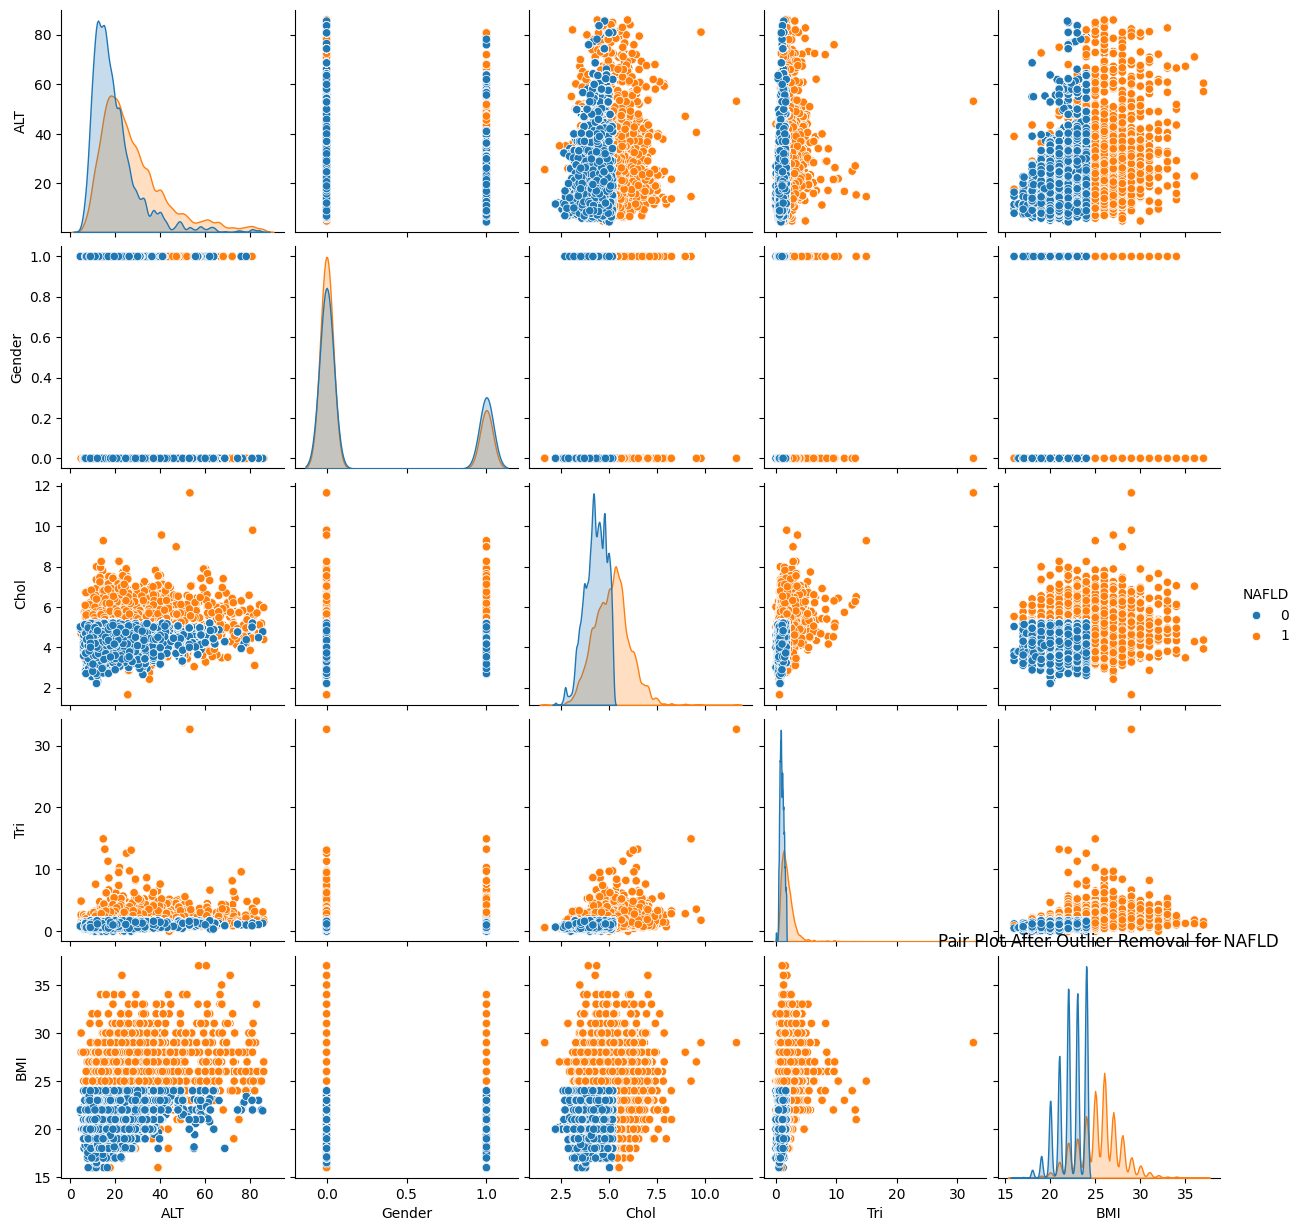

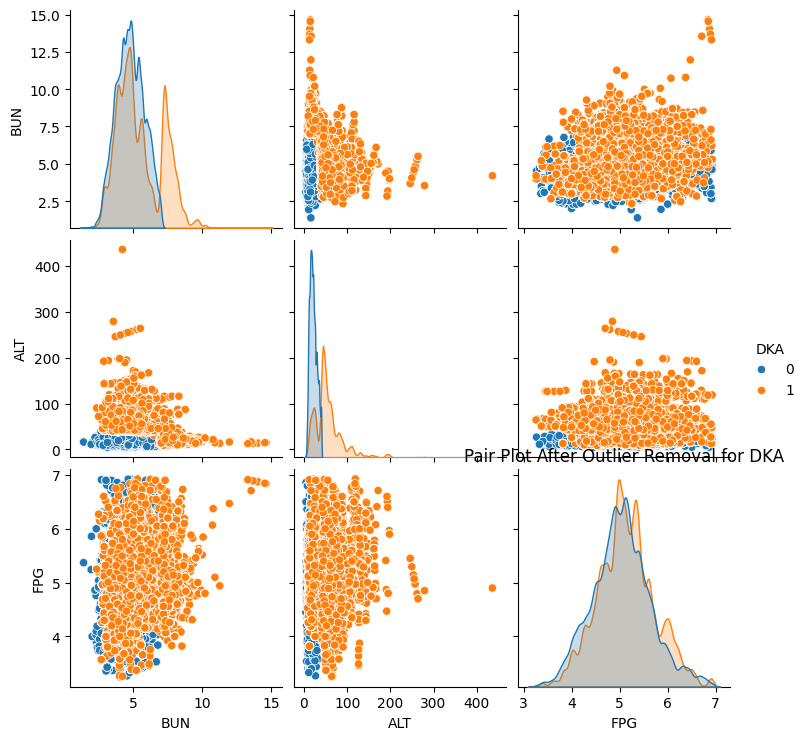

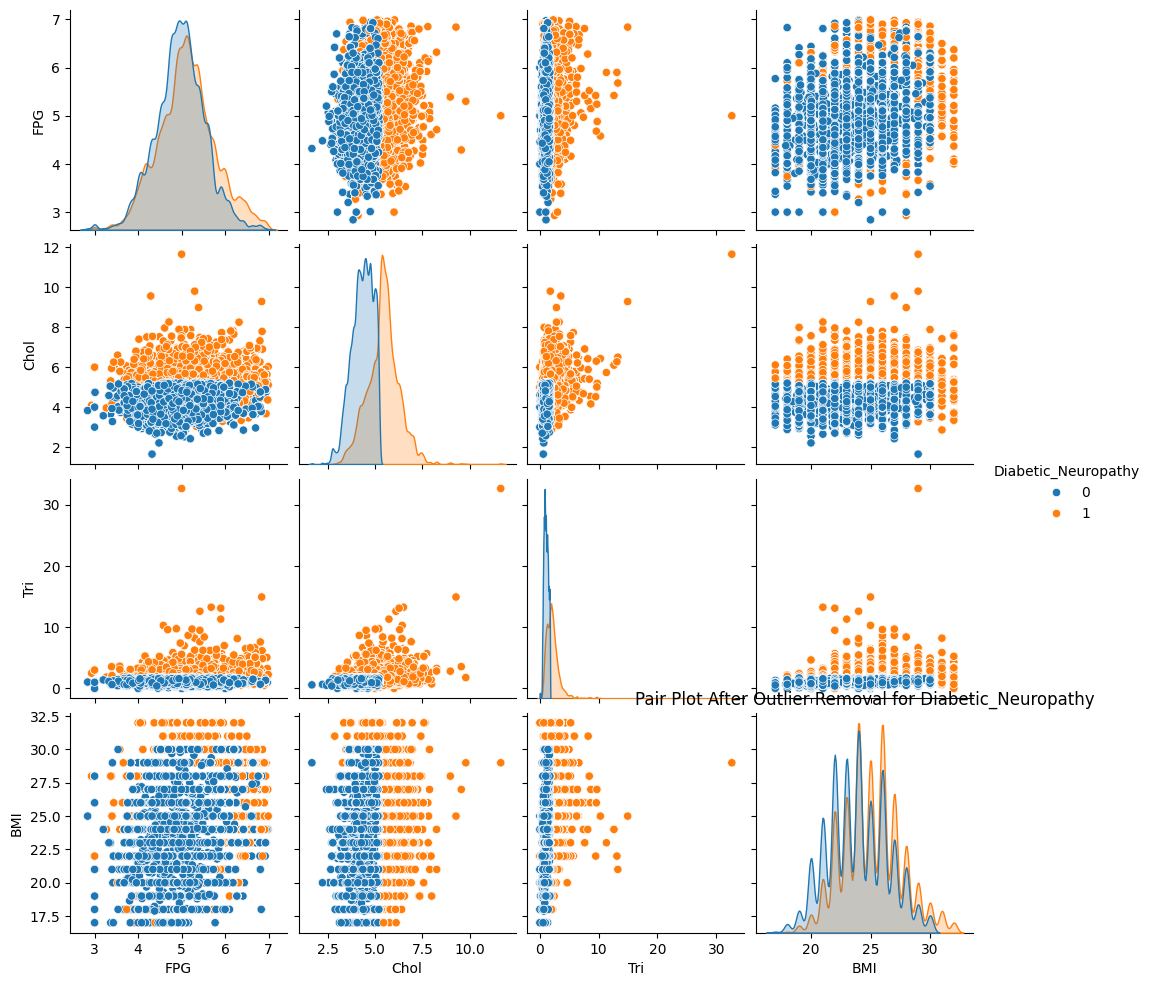

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the data after outlier removal
for disease, (X_filtered, y_filtered) in outliers_detected.items():
    # Create a DataFrame for visualization
    df_filtered = X_filtered.copy()
    df_filtered[disease] = y_filtered

    # Adjust the features for each disease
    if disease == 'DKA':
        features = ['BUN', 'ALT', 'FPG']  # Adjust based on your dataset
    elif disease == 'Diabetic_Retinopathy':
        features = ['FPG', 'Chol', 'HDL', 'LDL','HighBP','Tri']  # Adjust based on your dataset
    elif disease == 'NAFLD':
        features = ['ALT', 'Gender', 'Chol', 'Tri','BMI']  # Adjust based on your dataset
    elif disease == 'Diabetic_Neuropathy':
        features = ['FPG', 'Chol', 'Tri', 'BMI']

    # Plot pair plot
    sns.pairplot(df_filtered, hue=disease, vars=features)
    plt.title(f"Pair Plot After Outlier Removal for {disease}")
    plt.show()


In [83]:
%pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 347.4 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [86]:
# Assuming 'data' is your dataset containing all features and the four disease columns as targets

# Features (X): All columns except the four diseases
X = data.drop(columns=['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy'])

# Target (y): The four disease columns
y = data[['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']]

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Wrap it for multi-label classification
multi_rf = MultiOutputClassifier(rf_model)

# Train the model
multi_rf.fit(X_train, y_train)

# Make predictions on the test set
rf_pred = multi_rf.predict(X_test)


In [88]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize XGBoost
xgb_model = XGBClassifier(random_state=42)

# Wrap it for multi-label classification
multi_xgb = MultiOutputClassifier(xgb_model)

# Train the model
multi_xgb.fit(X_train, y_train)

# Make predictions on the test set
xgb_pred = multi_xgb.predict(X_test)


In [89]:
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize LightGBM
lgbm_model = LGBMClassifier(random_state=42)

# Wrap it for multi-label classification
multi_lgbm = MultiOutputClassifier(lgbm_model)

# Train the model
multi_lgbm.fit(X_train, y_train)

# Make predictions on the test set
lgbm_pred = multi_lgbm.predict(X_test)


[LightGBM] [Info] Number of positive: 30237, number of negative: 129721
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 159958, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189031 -> initscore=-1.456320
[LightGBM] [Info] Start training from score -1.456320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [90]:
from sklearn.metrics import classification_report

# Random Forest
print("Random Forest Classification Report:")
for i, disease in enumerate(['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']):
    print(f"\nReport for {disease}:")
    print(classification_report(y_test.iloc[:, i], rf_pred[:, i]))

# Similarly, you can do this for XGBoost and LightGBM


Random Forest Classification Report:

Report for DKA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32475
           1       1.00      1.00      1.00      7515

    accuracy                           1.00     39990
   macro avg       1.00      1.00      1.00     39990
weighted avg       1.00      1.00      1.00     39990


Report for Diabetic_Retinopathy:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14133
           1       1.00      1.00      1.00     25857

    accuracy                           1.00     39990
   macro avg       1.00      1.00      1.00     39990
weighted avg       1.00      1.00      1.00     39990


Report for NAFLD:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11639
           1       1.00      1.00      1.00     28351

    accuracy                           1.00     39990
   macro avg       1.

In [113]:
# Assuming 'data' contains the cleaned dataset with the four disease columns
X_filtered = data.drop(columns=['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy'])
y_filtered = data[['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']]


In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Wrap the model for multi-label classification
multi_rf = MultiOutputClassifier(rf_model)

# Fit the model
multi_rf.fit(X_filtered, y_filtered)

# Cross-validation for each disease column
for i, disease in enumerate(['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']):
    # Perform cross-validation for each label
    rf_scores = cross_val_score(rf_model, X_filtered, y_filtered[disease], cv=5, scoring='f1_macro')
    print(f"Cross-validated F1 Score for Random Forest ({disease}):", rf_scores.mean())


Cross-validated F1 Score for Random Forest (DKA): 0.9155032306311472
Cross-validated F1 Score for Random Forest (Diabetic_Retinopathy): 0.8760107531513726
Cross-validated F1 Score for Random Forest (NAFLD): 0.9376414480557835
Cross-validated F1 Score for Random Forest (Diabetic_Neuropathy): 0.9066348110842674


In [115]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Wrap the model for multi-label classification
multi_xgb = MultiOutputClassifier(xgb_model)

# Train the XGBoost model on the entire training set
multi_xgb.fit(X_filtered, y_filtered)

# Cross-validation for each disease column
for i, disease in enumerate(['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']):
    # Perform cross-validation for each label
    xgb_scores = cross_val_score(xgb_model, X_filtered, y_filtered[disease], cv=5, scoring='f1_macro')
    print(f"Cross-validated F1 Score for XGBoost ({disease}):", xgb_scores.mean())


Cross-validated F1 Score for XGBoost (DKA): 0.9920447251150921
Cross-validated F1 Score for XGBoost (Diabetic_Retinopathy): 0.9867849259656095
Cross-validated F1 Score for XGBoost (NAFLD): 0.9983281598655889
Cross-validated F1 Score for XGBoost (Diabetic_Neuropathy): 0.9996345337172523


In [168]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on the test set
y_pred = multi_xgb.predict(X_test)
y_proba = multi_xgb.predict_proba(X_test)

# Evaluate with classification report and ROC-AUC
for i, disease in enumerate(['DKA', 'Diabetic_Retinopathy', 'NAFLD', 'Diabetic_Neuropathy']):
    print(f"\nClassification Report for {disease}:")
    print(classification_report(y_test[disease], y_pred[:, i]))
    roc_auc = roc_auc_score(y_test[disease], y_proba[i][:, 1])
    print(f"ROC-AUC Score for {disease}: {roc_auc}")



Classification Report for DKA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32493
           1       1.00      1.00      1.00      7496

    accuracy                           1.00     39989
   macro avg       1.00      1.00      1.00     39989
weighted avg       1.00      1.00      1.00     39989

ROC-AUC Score for DKA: 1.0

Classification Report for Diabetic_Retinopathy:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14390
           1       1.00      1.00      1.00     25599

    accuracy                           1.00     39989
   macro avg       1.00      1.00      1.00     39989
weighted avg       1.00      1.00      1.00     39989

ROC-AUC Score for Diabetic_Retinopathy: 1.0

Classification Report for NAFLD:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11749
           1       1.00      1.00      1.00     282

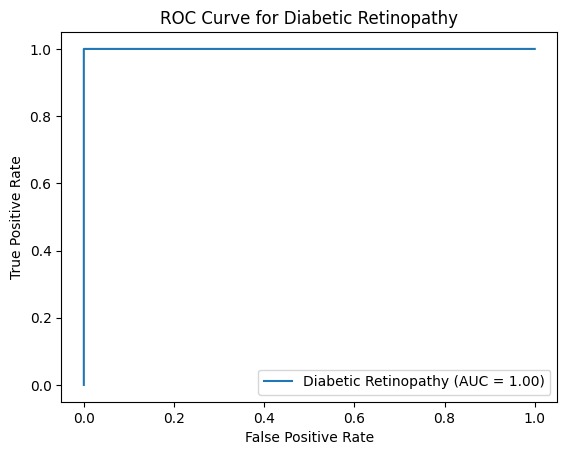

In [120]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_auc(y_test, y_proba, disease_name):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{disease_name} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {disease_name}')
    plt.legend()
    plt.show()

# Predict probabilities for each disease label separately
y_proba_xgb = multi_xgb.predict_proba(X_test)  # List of arrays for each label

# Example: Plot ROC Curve for Diabetic Retinopathy
disease_idx = 1  # Index of 'Diabetic_Retinopathy' in the target labels
y_test_retinopathy = y_test['Diabetic_Retinopathy']
y_proba_retinopathy = y_proba_xgb[disease_idx][:, 1]  # Use index 1 for positive class probability
plot_roc_auc(y_test_retinopathy, y_proba_retinopathy, 'Diabetic Retinopathy')


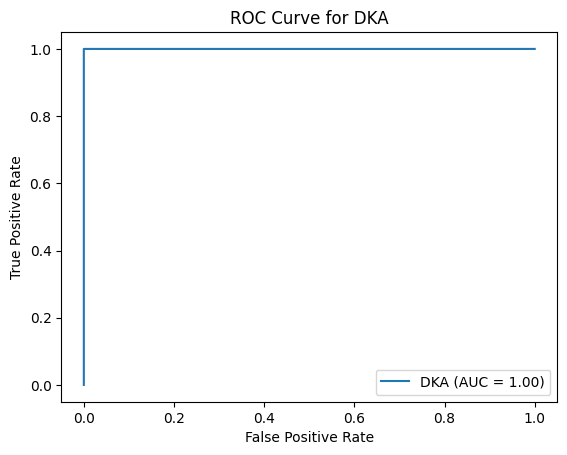

In [121]:
# Example: Plot ROC Curve for DKA
disease_idx = 0  # Index for 'DKA'
y_test_dka = y_test['DKA']
y_proba_dka = y_proba_xgb[disease_idx][:, 1]  # Use index 1 for positive class probability
plot_roc_auc(y_test_dka, y_proba_dka, 'DKA')


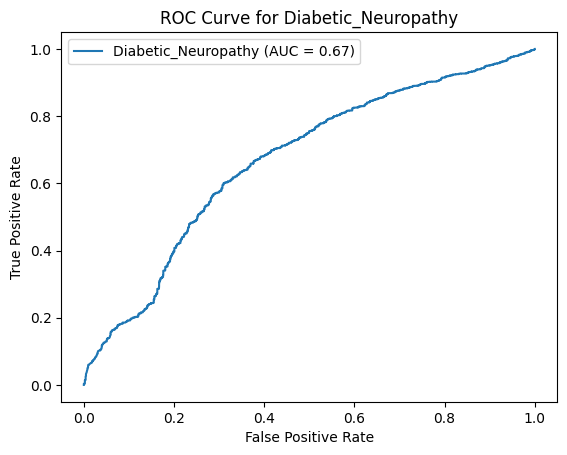

In [123]:
# Example: Plot ROC Curve for DKA
disease_idx = 0  # Index for 'DKA'
y_test_dka = y_test['Diabetic_Neuropathy']
y_proba_dka = y_proba_xgb[disease_idx][:, 1]  # Use index 1 for positive class probability
plot_roc_auc(y_test_dka, y_proba_dka, 'Diabetic_Neuropathy')

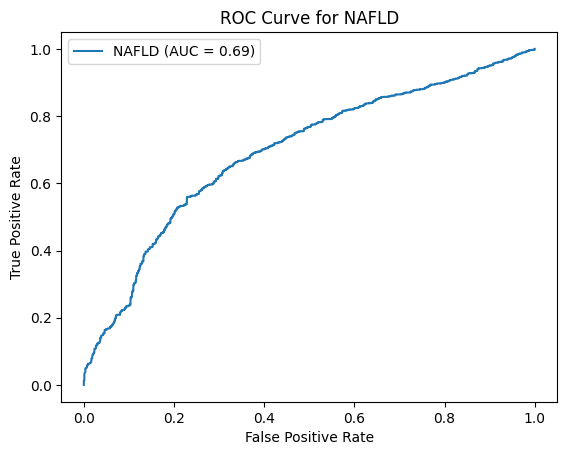

In [122]:
# Example: Plot ROC Curve for DKA
disease_idx = 0  # Index for 'DKA'
y_test_dka = y_test['NAFLD']
y_proba_dka = y_proba_xgb[disease_idx][:, 1]  # Use index 1 for positive class probability
plot_roc_auc(y_test_dka, y_proba_dka, 'NAFLD')

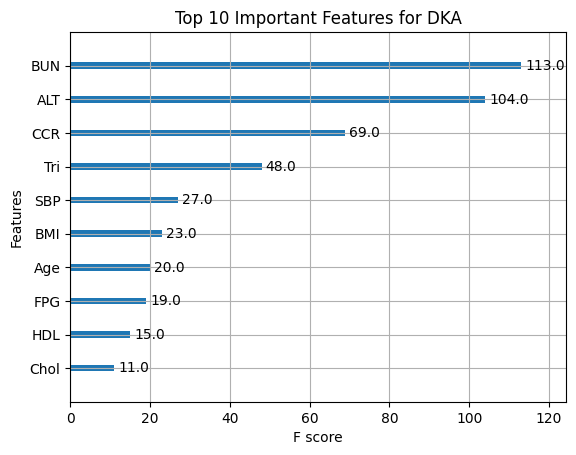

In [124]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Train XGBoost model specifically for DKA
xgb_dka = XGBClassifier(random_state=42)
xgb_dka.fit(X_train, y_train['DKA'])

# Plot feature importance for DKA
xgb.plot_importance(xgb_dka, max_num_features=10)
plt.title("Top 10 Important Features for DKA")
plt.show()


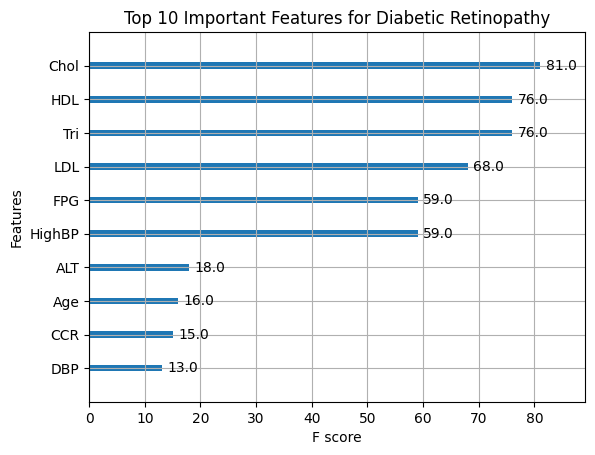

In [125]:
# Train XGBoost model specifically for Diabetic Retinopathy
xgb_retinopathy = XGBClassifier(random_state=42)
xgb_retinopathy.fit(X_train, y_train['Diabetic_Retinopathy'])

# Plot feature importance for Diabetic Retinopathy
xgb.plot_importance(xgb_retinopathy, max_num_features=10)
plt.title("Top 10 Important Features for Diabetic Retinopathy")
plt.show()


/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


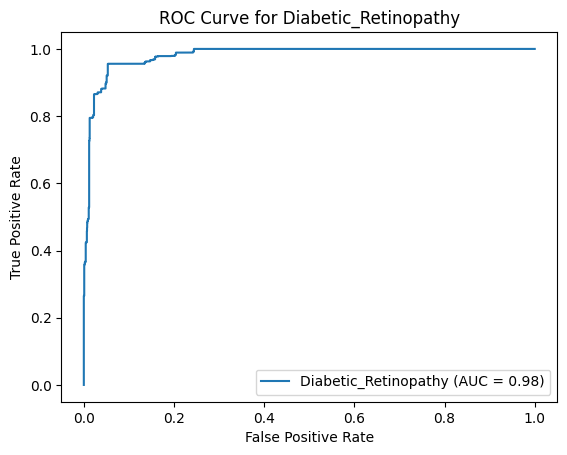

In [159]:
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

# Define XGBoost model with regularization
xgb_model_balanced_regularization = XGBClassifier(
    random_state=42,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    lambda_=100,  # Reasonable L2 regularization
    alpha=7500,    # Moderate L1 regularization
    subsample=0.7,
    colsample_bytree=0.7
)


# Train model for DKA with regularization
xgb_model_balanced_regularization.fit(X_train, y_train['Diabetic_Retinopathy'])

# Evaluate the model
y_proba_dka = xgb_model_balanced_regularization.predict_proba(X_test)[:, 1]  # For DKA
plot_roc_auc(y_test['Diabetic_Retinopathy'], y_proba_dka, 'Diabetic_Retinopathy')


/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


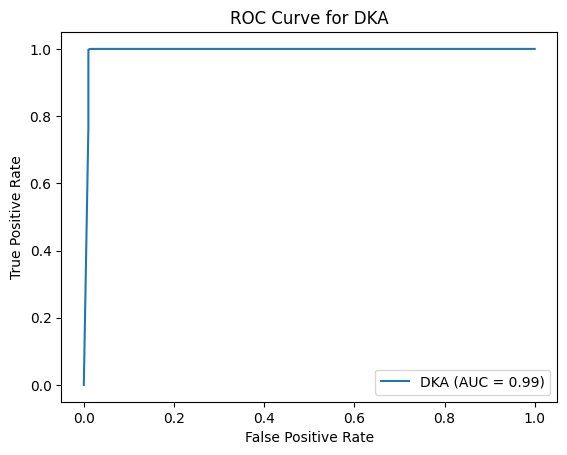

In [162]:
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

# Define XGBoost model with regularization
xgb_model_balanced_regularization = XGBClassifier(
    random_state=42,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    lambda_=100,  # Reasonable L2 regularization
    alpha=15000,    # Moderate L1 regularization
    subsample=0.7,
    colsample_bytree=0.7
)


# Train model for DKA with regularization
xgb_model_balanced_regularization.fit(X_train, y_train['DKA'])

# Evaluate the model
y_proba_dka = xgb_model_balanced_regularization.predict_proba(X_test)[:, 1]  # For DKA
plot_roc_auc(y_test['DKA'], y_proba_dka, 'DKA')


In [163]:
from sklearn.metrics import classification_report

# Example: Classification report for DKA
y_pred_dka = xgb_model_balanced_regularization.predict(X_test)
print("Classification Report for DKA:")
print(classification_report(y_test['DKA'], y_pred_dka))


Classification Report for DKA:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     32493
           1       0.00      0.00      0.00      7496

    accuracy                           0.81     39989
   macro avg       0.41      0.50      0.45     39989
weighted avg       0.66      0.81      0.73     39989



/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [164]:
from sklearn.metrics import classification_report

# Example: Classification report for DKA
y_pred_dka = xgb_model_balanced_regularization.predict(X_test)
print("Classification Report for Diabetic_Retinopathy:")
print(classification_report(y_test['Diabetic_Retinopathy'], y_pred_dka))

Classification Report for Diabetic_Retinopathy:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53     14390
           1       0.00      0.00      0.00     25599

    accuracy                           0.36     39989
   macro avg       0.18      0.50      0.26     39989
weighted avg       0.13      0.36      0.19     39989



/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [165]:
from sklearn.metrics import classification_report

# Example: Classification report for DKA
y_pred_dka = xgb_model_balanced_regularization.predict(X_test)
print("Classification Report for NAFLD:")
print(classification_report(y_test['NAFLD'], y_pred_dka))

Classification Report for NAFLD:
              precision    recall  f1-score   support

           0       0.29      1.00      0.45     11749
           1       0.00      0.00      0.00     28240

    accuracy                           0.29     39989
   macro avg       0.15      0.50      0.23     39989
weighted avg       0.09      0.29      0.13     39989



/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [166]:
from sklearn.metrics import classification_report

# Example: Classification report for DKA
y_pred_dka = xgb_model_balanced_regularization.predict(X_test)
print("Classification Report for Diabetic_Neuropathy:")
print(classification_report(y_test['Diabetic_Neuropathy'], y_pred_dka))

Classification Report for Diabetic_Neuropathy:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65     19275
           1       0.00      0.00      0.00     20714

    accuracy                           0.48     39989
   macro avg       0.24      0.50      0.33     39989
weighted avg       0.23      0.48      0.31     39989



/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karmesh/Desktop/minor_poject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier